![Henry Logo](https://www.soyhenry.com/_next/static/media/HenryLogo.bb57fd6f.svg)

# Bases de Datos Vectoriales - Patrones de Produccion

## Objetivos de aprendizaje

Al finalizar esta notebook seras capaz de:

1. Usar FAISS para busqueda vectorial de alto rendimiento
2. Comparar FAISS vs ChromaDB en los mismos queries
3. Aplicar diferentes estrategias de chunking y medir su impacto
4. Persistir y recargar indices vectoriales
5. Comparar modelos de embeddings (OpenAI vs HuggingFace)
6. Medir rendimiento: velocidad de indexado, busqueda y memoria

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import chromadb
import time
import sys
import shutil
import os
from dotenv import find_dotenv, load_dotenv
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma, FAISS as LangchainFAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
import warnings
warnings.filterwarnings('ignore')

load_dotenv(find_dotenv())

client = OpenAI()
print("Todas las dependencias cargadas correctamente.")

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Todas las dependencias cargadas correctamente.


---
## Dataset: NovaTech Solutions (expandido)

Usaremos la base de conocimiento interna de **NovaTech Solutions**, una empresa ficticia de tecnologia. Estos documentos contienen datos especificos que ningun modelo puede adivinar.

In [2]:
novatech_docs = [
    # Politica de vacaciones
    """Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen derecho a 22 dias habiles de vacaciones al anio, acumulables hasta un maximo de 
    44 dias. Los primeros 6 meses son periodo de prueba y solo se acumulan 1.5 dias por mes. 
    Las vacaciones deben solicitarse con al menos 15 dias de anticipacion a traves del sistema 
    interno VacaTrack v3.2. El periodo de vacaciones colectivas es del 23 de diciembre al 2 de 
    enero. Los dias no utilizados se pueden compensar economicamente al 75% del valor diario 
    del salario base. El director de cada area debe aprobar las solicitudes en un plazo maximo 
    de 3 dias habiles.""",

    # Plan de salud
    """Plan de Salud Corporativo NovaTech. La empresa ofrece cobertura medica a traves de 
    MediPlus Premium para todos los empleados y sus dependientes directos (conyuge e hijos 
    menores de 25 anios). La cobertura incluye: consultas generales y especialistas con copago 
    de $150 MXN, hospitalizacion con cobertura al 90%, medicamentos con descuento del 40% en 
    FarmaRed, dental basico incluido y dental estetico con 50% de cobertura. El tope anual de 
    cobertura es de $2,000,000 MXN por beneficiario. La empresa absorbe el 80% de la prima 
    mensual y el empleado el 20% restante via nomina. Para emergencias fuera de horario llamar 
    a la linea 800-NOVA-MED (800-668-2633).""",

    # Proceso de onboarding
    """Proceso de Onboarding en NovaTech Solutions. El programa de integracion dura 4 semanas 
    y sigue la metodologia NOVA-Start. Semana 1: Setup tecnico (laptop, cuentas, VPN Cisco 
    AnyConnect, acceso a GitLab), reunion con HR y firma de NDA. Semana 2: Sesiones con cada 
    area del producto, introduccion a la arquitectura de DataPulse y al stack tecnologico. 
    Semana 3: Asignacion de buddy (mentor) y primer ticket de practica en el sprint actual. 
    Semana 4: Evaluacion de onboarding con el tech lead y definicion de OKRs del primer 
    trimestre. Cada nuevo empleado recibe un kit de bienvenida que incluye: laptop Dell XPS 15, 
    monitor ultrawide 34 pulgadas, teclado mecanico y $5,000 MXN en credito para setup de 
    home office.""",

    # Stack tecnologico
    """Stack Tecnologico de NovaTech Solutions. Backend: FastAPI 0.109 sobre Python 3.12, con 
    PostgreSQL 16 como base de datos principal y Redis 7.2 para cache y colas. Frontend: 
    React 18 con TypeScript 5.3, Next.js 14 para SSR, y TailwindCSS 3.4 para estilos. 
    Infraestructura: AWS con EKS (Kubernetes 1.28), Terraform para IaC, ArgoCD para GitOps 
    y Datadog para observabilidad. CI/CD: GitLab CI con runners dedicados en m6i.xlarge, 
    pipelines de ~8 minutos promedio. El monorepo tiene aproximadamente 340,000 lineas de 
    codigo y 94% de cobertura de tests. Usamos arquitectura de microservicios con 23 
    servicios principales comunicados via gRPC y eventos en Apache Kafka 3.6.""",

    # Evaluaciones de desempeno
    """Sistema de Evaluaciones de NovaTech. Las evaluaciones de desempeno se realizan cada 6 
    meses usando la plataforma NovaPerf v2.1. El proceso incluye: autoevaluacion (20% del 
    peso), evaluacion del manager directo (40%), evaluacion de peers (30%) y evaluacion de 
    reportes directos si aplica (10%). La escala es de 1 a 5: 1-Necesita mejora, 2-En 
    desarrollo, 3-Cumple expectativas, 4-Supera expectativas, 5-Excepcional. Los empleados 
    con calificacion 4+ son elegibles para el programa de Fast Track que incluye aumento 
    salarial del 15-20% y acceso a proyectos estrategicos. La calibracion de evaluaciones 
    se realiza en comite con VPs de cada area.""",

    # Politica de trabajo remoto
    """Politica de Trabajo Remoto NovaTech. La empresa opera bajo modelo hibrido 3-2: 3 dias 
    en oficina (martes, miercoles, jueves) y 2 dias remotos (lunes, viernes). Las oficinas 
    principales estan en Ciudad de Mexico (Torre NOVA, piso 12-15, Santa Fe) y Guadalajara 
    (WeWork Midtown). Se permite trabajo 100% remoto temporal por hasta 4 semanas al anio 
    con aprobacion del VP. Para trabajo remoto internacional se requiere aprobacion de Legal 
    y HR con 30 dias de anticipacion. El subsidio mensual de internet es de $800 MXN y se 
    proporciona una silla ergonomica Herman Miller Aeron en comodato. Las reuniones de 
    all-hands son los miercoles a las 10:00 AM CST via Google Meet.""",

    # Programa de capacitacion
    """Programa de Capacitacion y Desarrollo NovaTech. Cada empleado cuenta con un presupuesto 
    anual de $25,000 MXN para capacitacion profesional. Esto cubre: cursos online (Udemy, 
    Coursera, Platzi), conferencias (hasta 2 al anio con viaticos incluidos), certificaciones 
    tecnicas (AWS, GCP, Kubernetes). La plataforma interna LearnHub tiene 150+ cursos creados 
    por empleados senior. Los viernes de 2-4 PM son 'Learning Hours' protegidas donde no se 
    agendan reuniones. El programa de mentoria NOVA-Grow conecta juniors con seniors por 6 
    meses con sesiones quincenales de 1 hora. Los tech talks internos son los jueves a las 
    5 PM y se graban en el canal #tech-talks de Slack.""",

    # Producto DataPulse
    """DataPulse - Producto Principal de NovaTech Solutions. DataPulse es una plataforma de 
    analytics en tiempo real para empresas de e-commerce y fintech. Procesa en promedio 2.3 
    millones de eventos por minuto con una latencia p99 de 45ms. El SLA garantizado es de 
    99.95% de disponibilidad mensual, con creditos automaticos del 10% de la factura por cada 
    0.01% por debajo del SLA. DataPulse tiene 3 tiers: Starter ($2,500 USD/mes, hasta 10M 
    eventos/dia), Business ($8,000 USD/mes, hasta 100M eventos/dia) y Enterprise (precio 
    custom, eventos ilimitados, soporte dedicado 24/7). Actualmente tiene 847 clientes 
    activos en 12 paises de LATAM y procesó $3.2 billones USD en transacciones monitoreadas 
    durante 2024.""",

    # Politica de seguridad informatica
    """Politica de Seguridad Informatica NovaTech. Todos los empleados deben completar el 
    entrenamiento de seguridad SecureNova cada 6 meses. Las contraseñas deben tener minimo 
    16 caracteres y rotarse cada 90 dias. Se usa autenticacion multifactor (MFA) obligatoria 
    con YubiKey 5 NFC para acceso a sistemas criticos. El escaneo de vulnerabilidades se 
    ejecuta semanalmente con Qualys y las findings criticas deben resolverse en 48 horas. 
    Los pentest externos se realizan trimestralmente con la firma CyberGuard MX. El equipo 
    de seguridad (5 personas) reporta directamente al CTO.""",

    # Beneficios adicionales
    """Beneficios Adicionales NovaTech Solutions. Ademas del salario base, los empleados 
    reciben: vales de despensa por $3,500 MXN mensuales (TotalPass), fondo de ahorro con 
    aportacion patronal del 8%, seguro de vida por 48 meses de sueldo, bono anual basado 
    en desempeno (target del 15% del salario anual), programa de stock options despues de 
    2 anios de antiguedad (vesting de 4 anios con cliff de 1 anio), descuento del 30% en 
    gimnasios asociados (Sport City, Smart Fit), y acceso gratuito a la app de salud mental 
    TherapyChat con 4 sesiones mensuales incluidas. El Employee Referral Bonus es de $15,000 
    MXN por cada contratacion exitosa referida.""",

    # Arquitectura de DataPulse detallada
    """Arquitectura Tecnica de DataPulse. El sistema usa una arquitectura event-driven con 
    Apache Kafka como backbone de mensajeria. Los eventos ingresan via API Gateway (Kong) y 
    se procesan en 3 pipelines: real-time (Apache Flink para agregaciones sub-segundo), 
    near-real-time (Apache Spark Structured Streaming para enriquecimiento) y batch (Apache 
    Spark para reportes historicos). El almacenamiento usa una lakehouse architecture con 
    Delta Lake sobre S3, ClickHouse para queries OLAP interactivos y Redis para dashboards 
    en tiempo real. El ML pipeline usa MLflow para experiment tracking y Kubeflow para 
    training pipelines. Los modelos de deteccion de anomalias se reentrenan cada 24 horas 
    con los ultimos 30 dias de datos.""",

    # Politica de incidentes
    """Protocolo de Manejo de Incidentes NovaTech. Los incidentes se clasifican en 4 niveles: 
    SEV1 (caida total del servicio, respuesta en 5 minutos, war room inmediato), SEV2 
    (degradacion significativa, respuesta en 15 minutos), SEV3 (impacto menor, respuesta en 
    1 hora) y SEV4 (cosmético, siguiente sprint). El on-call rota semanalmente entre 12 
    ingenieros senior con compensacion de $8,000 MXN por semana de guardia. Post-mortem 
    obligatorio para SEV1 y SEV2 dentro de 48 horas usando el template NOVA-Incident en 
    Confluence. El MTTR (Mean Time To Recovery) objetivo es de 30 minutos para SEV1. Se 
    usa PagerDuty para alertas y Slack channel #incidents para coordinacion.""",

    # Proceso de desarrollo
    """Proceso de Desarrollo en NovaTech. Usamos Scrum con sprints de 2 semanas. Cada equipo 
    (squad) tiene 5-7 personas: 1 PM, 1 tech lead, 3-4 developers y 1 QA. Actualmente hay 
    8 squads organizados por dominio: Ingest, Processing, Storage, Analytics, API, Frontend, 
    Platform e Infra. El Definition of Done incluye: code review aprobado por al menos 2 
    peers, tests unitarios con >90% cobertura, tests de integracion, documentacion en 
    Notion actualizada, y validacion de QA en staging. Los deployments a produccion son 
    automaticos via ArgoCD con canary releases (5% -> 25% -> 100%) y rollback automatico 
    si el error rate supera el 0.1%.""",
]

print(f"Documentos cargados: {len(novatech_docs)}")
print(f"Caracteres totales: {sum(len(d) for d in novatech_docs):,}")
print(f"Caracteres promedio por documento: {np.mean([len(d) for d in novatech_docs]):.0f}")

Documentos cargados: 13
Caracteres totales: 9,046
Caracteres promedio por documento: 696


---
## Seccion 1: FAISS - Facebook AI Similarity Search

**FAISS** es una libreria de Meta/Facebook optimizada para busqueda de similitud en vectores de alta dimension. Es significativamente mas rapida que ChromaDB para datasets grandes.

Diferencias clave:
- FAISS: optimizado para velocidad, indices en memoria, sin metadata nativa
- ChromaDB: mas features (metadata, persistencia facil), mas lento

### 1.1 FAISS raw (sin LangChain)

In [3]:
# Generar embeddings
resp = client.embeddings.create(input=novatech_docs, model="text-embedding-3-small")
doc_embeddings = np.array([e.embedding for e in resp.data], dtype=np.float32)

print(f"Shape de embeddings: {doc_embeddings.shape}")

# Crear indice FAISS (L2 = distancia euclidiana)
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings)

print(f"Vectores en el indice: {index.ntotal}")

Shape de embeddings: (13, 1536)
Vectores en el indice: 13


In [4]:
# Buscar con FAISS
query = "cual es el stack tecnologico del backend"
q_resp = client.embeddings.create(input=[query], model="text-embedding-3-small")
query_emb = np.array([q_resp.data[0].embedding], dtype=np.float32)

distances, indices = index.search(query_emb, k=3)

print(f"Query: '{query}'")
print("=" * 60)
for i, (dist, idx) in enumerate(zip(distances[0], indices[0]), 1):
    print(f"\n  {i}. [distancia L2: {dist:.4f}] (doc #{idx})")
    print(f"     {novatech_docs[idx][:120]}...")

Query: 'cual es el stack tecnologico del backend'

  1. [distancia L2: 0.7941] (doc #3)
     Stack Tecnologico de NovaTech Solutions. Backend: FastAPI 0.109 sobre Python 3.12, con 
    PostgreSQL 16 como base de d...

  2. [distancia L2: 1.0650] (doc #12)
     Proceso de Desarrollo en NovaTech. Usamos Scrum con sprints de 2 semanas. Cada equipo 
    (squad) tiene 5-7 personas: 1...

  3. [distancia L2: 1.0714] (doc #10)
     Arquitectura Tecnica de DataPulse. El sistema usa una arquitectura event-driven con 
    Apache Kafka como backbone de m...


### 1.2 FAISS con LangChain

In [5]:
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Crear documentos LangChain
lc_docs = [Document(page_content=doc) for doc in novatech_docs]

# Crear vectorstore FAISS con LangChain
faiss_store = LangchainFAISS.from_documents(lc_docs, embeddings_model)

# Buscar
results = faiss_store.similarity_search_with_score(query, k=3)

print(f"Query: '{query}'")
print("=" * 60)
for i, (doc, score) in enumerate(results, 1):
    print(f"\n  {i}. [score: {score:.4f}]")
    print(f"     {doc.page_content[:120]}...")

Query: 'cual es el stack tecnologico del backend'

  1. [score: 0.7941]
     Stack Tecnologico de NovaTech Solutions. Backend: FastAPI 0.109 sobre Python 3.12, con 
    PostgreSQL 16 como base de d...

  2. [score: 1.0650]
     Proceso de Desarrollo en NovaTech. Usamos Scrum con sprints de 2 semanas. Cada equipo 
    (squad) tiene 5-7 personas: 1...

  3. [score: 1.0714]
     Arquitectura Tecnica de DataPulse. El sistema usa una arquitectura event-driven con 
    Apache Kafka como backbone de m...


### 1.3 Comparacion FAISS vs ChromaDB

In [6]:
# Crear ChromaDB con los mismos documentos
chroma_store = Chroma.from_documents(lc_docs, embeddings_model)

# Queries de prueba
test_queries = [
    "cuantos dias de vacaciones tienen los empleados",
    "cual es el SLA de DataPulse",
    "como es el proceso de onboarding",
    "que herramientas usan para CI/CD",
    "presupuesto de capacitacion por empleado",
]

print("Comparacion FAISS vs ChromaDB")
print("=" * 60)

for q in test_queries:
    faiss_results = faiss_store.similarity_search(q, k=1)
    chroma_results = chroma_store.similarity_search(q, k=1)

    faiss_text = faiss_results[0].page_content[:80]
    chroma_text = chroma_results[0].page_content[:80]
    match = "SI" if faiss_text == chroma_text else "NO"

    print(f"\nQuery: '{q}'")
    print(f"  FAISS:  {faiss_text}...")
    print(f"  Chroma: {chroma_text}...")
    print(f"  Coinciden: {match}")
    print("-" * 50)

Comparacion FAISS vs ChromaDB



Query: 'cuantos dias de vacaciones tienen los empleados'
  FAISS:  Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo comp...
  Chroma: Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo comp...
  Coinciden: SI
--------------------------------------------------



Query: 'cual es el SLA de DataPulse'
  FAISS:  DataPulse - Producto Principal de NovaTech Solutions. DataPulse es una plataform...
  Chroma: DataPulse - Producto Principal de NovaTech Solutions. DataPulse es una plataform...
  Coinciden: SI
--------------------------------------------------



Query: 'como es el proceso de onboarding'
  FAISS:  Proceso de Onboarding en NovaTech Solutions. El programa de integracion dura 4 s...
  Chroma: Proceso de Onboarding en NovaTech Solutions. El programa de integracion dura 4 s...
  Coinciden: SI
--------------------------------------------------



Query: 'que herramientas usan para CI/CD'
  FAISS:  Proceso de Desarrollo en NovaTech. Usamos Scrum con sprints de 2 semanas. Cada e...
  Chroma: Proceso de Desarrollo en NovaTech. Usamos Scrum con sprints de 2 semanas. Cada e...
  Coinciden: SI
--------------------------------------------------



Query: 'presupuesto de capacitacion por empleado'
  FAISS:  Programa de Capacitacion y Desarrollo NovaTech. Cada empleado cuenta con un pres...
  Chroma: Programa de Capacitacion y Desarrollo NovaTech. Cada empleado cuenta con un pres...
  Coinciden: SI
--------------------------------------------------


---
## Seccion 2: Estrategias de Chunking

Los documentos largos deben dividirse en **chunks** (fragmentos) antes de indexarlos. El tamano del chunk afecta directamente la calidad del retrieval:

- **Chunks muy pequenos**: pierden contexto, pueden no contener la respuesta completa
- **Chunks muy grandes**: mezclan temas, reducen la precision de la busqueda
- **Overlap**: repite texto entre chunks consecutivos para no perder informacion en los bordes

In [7]:
# Tres configuraciones de chunking
configs = {
    'Pequeno (200/20)': {'chunk_size': 200, 'chunk_overlap': 20},
    'Mediano (500/50)': {'chunk_size': 500, 'chunk_overlap': 50},
    'Grande (1000/100)': {'chunk_size': 1000, 'chunk_overlap': 100},
}

all_text = "\n\n".join(novatech_docs)

chunks_por_config = {}
for name, params in configs.items():
    splitter = RecursiveCharacterTextSplitter(**params)
    chunks = splitter.split_text(all_text)
    chunks_por_config[name] = chunks

    print(f"{name}:")
    print(f"  Chunks generados: {len(chunks)}")
    print(f"  Largo promedio: {np.mean([len(c) for c in chunks]):.0f} chars")
    print(f"  Largo min/max: {min(len(c) for c in chunks)}/{max(len(c) for c in chunks)} chars")
    print()

Pequeno (200/20):
  Chunks generados: 54
  Largo promedio: 163 chars
  Largo min/max: 12/194 chars

Mediano (500/50):
  Chunks generados: 26
  Largo promedio: 345 chars
  Largo min/max: 146/462 chars

Grande (1000/100):
  Chunks generados: 13
  Largo promedio: 696 chars
  Largo min/max: 601/759 chars



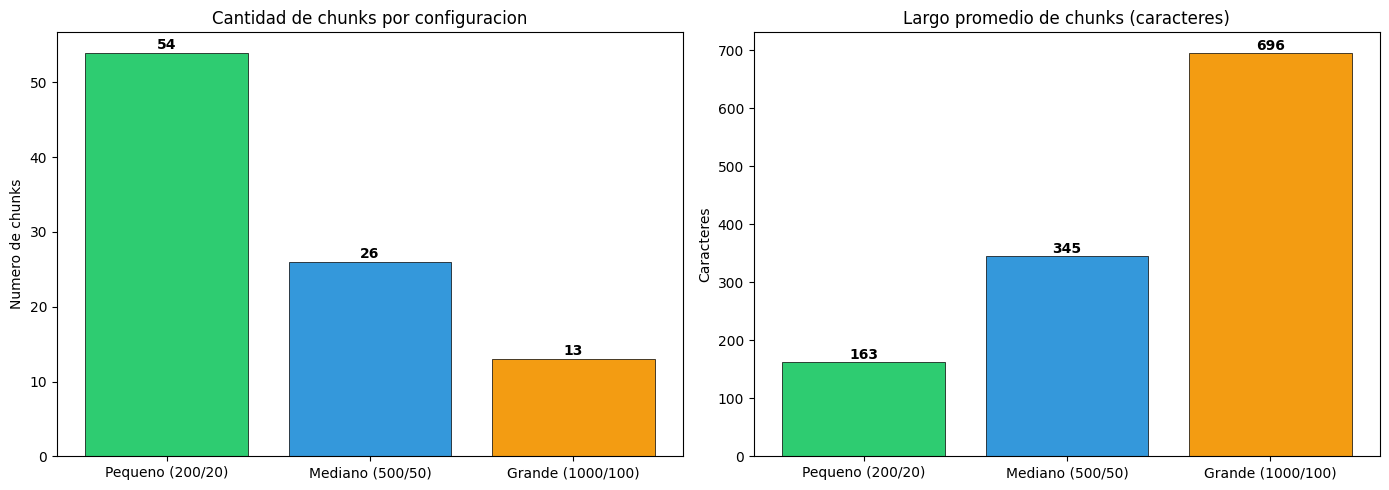

In [8]:
# Visualizacion: cantidad de chunks y largo promedio
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

nombres = list(configs.keys())
n_chunks = [len(chunks_por_config[n]) for n in nombres]
avg_len = [np.mean([len(c) for c in chunks_por_config[n]]) for n in nombres]
colores = ['#2ecc71', '#3498db', '#f39c12']

axes[0].bar(nombres, n_chunks, color=colores, edgecolor='black', linewidth=0.5)
axes[0].set_title('Cantidad de chunks por configuracion')
axes[0].set_ylabel('Numero de chunks')
for i, v in enumerate(n_chunks):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

axes[1].bar(nombres, avg_len, color=colores, edgecolor='black', linewidth=0.5)
axes[1].set_title('Largo promedio de chunks (caracteres)')
axes[1].set_ylabel('Caracteres')
for i, v in enumerate(avg_len):
    axes[1].text(i, v + 5, f"{v:.0f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# Mostrar chunks reales del primer documento para comparar
primer_doc = novatech_docs[0]
print(f"Documento original ({len(primer_doc)} chars):")
print(primer_doc[:200] + "...")
print()

for name, params in configs.items():
    splitter = RecursiveCharacterTextSplitter(**params)
    chunks = splitter.split_text(primer_doc)
    print(f"\n{'=' * 60}")
    print(f"{name}: {len(chunks)} chunks")
    print("=" * 60)
    for i, chunk in enumerate(chunks[:3]):  # Mostrar solo los primeros 3
        print(f"\n  Chunk {i+1} ({len(chunk)} chars):")
        print(f"  '{chunk[:100]}...'")

Documento original (676 chars):
Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen derecho a 22 dias habiles de vacaciones al anio, acumulables hasta un maximo de 
    44 dias. Los prime...


Pequeno (200/20): 4 chunks

  Chunk 1 (176 chars):
  'Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen der...'

  Chunk 2 (184 chars):
  '44 dias. Los primeros 6 meses son periodo de prueba y solo se acumulan 1.5 dias por mes. 
    Las va...'

  Chunk 3 (184 chars):
  'interno VacaTrack v3.2. El periodo de vacaciones colectivas es del 23 de diciembre al 2 de 
    ener...'

Mediano (500/50): 2 chunks

  Chunk 1 (462 chars):
  'Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen der...'

  Chunk 2 (208 chars):
  'enero. Los dias no utilizados se pueden compensar economicamente al 75% del valor diario 
    del sa...'

Grande (1000/100): 1 chunks

  Chunk 1 (676 ch

---
## Seccion 3: Efecto del Chunk Size en Retrieval

Creemos una coleccion por cada configuracion de chunking y midamos como afecta la relevancia de los resultados.

In [10]:
# Crear una coleccion Chroma por configuracion
stores = {}
for name, chunks in chunks_por_config.items():
    docs = [Document(page_content=c) for c in chunks]
    stores[name] = Chroma.from_documents(docs, embeddings_model)
    print(f"{name}: {len(chunks)} chunks indexados")

Pequeno (200/20): 54 chunks indexados


Mediano (500/50): 26 chunks indexados


Grande (1000/100): 13 chunks indexados


In [11]:
# Queries de prueba con respuestas conocidas
eval_queries = [
    "cuantos dias de vacaciones tienen los empleados",
    "cual es el SLA de DataPulse",
    "que tecnologias usa el backend",
    "cuanto es el presupuesto de capacitacion",
    "como funciona el proceso de onboarding",
]

# Palabras clave esperadas en las respuestas
expected_keywords = [
    ["22", "dias", "vacaciones"],
    ["99.95", "SLA", "DataPulse"],
    ["FastAPI", "PostgreSQL", "Redis"],
    ["25,000", "capacitacion"],
    ["4 semanas", "buddy", "onboarding"],
]

# Evaluar
relevance_matrix = []
config_names = list(stores.keys())

for q_idx, (query, keywords) in enumerate(zip(eval_queries, expected_keywords)):
    row = []
    for config_name in config_names:
        results = stores[config_name].similarity_search(query, k=3)
        combined_text = " ".join([r.page_content for r in results])
        # Score: proporcion de keywords encontradas
        found = sum(1 for kw in keywords if kw.lower() in combined_text.lower())
        score = found / len(keywords)
        row.append(score)
    relevance_matrix.append(row)

relevance_df = pd.DataFrame(
    relevance_matrix,
    index=[q[:40] + "..." for q in eval_queries],
    columns=config_names,
)

print("Matriz de relevancia (proporcion de keywords encontradas):")
print(relevance_df.to_string())

Matriz de relevancia (proporcion de keywords encontradas):
                                             Pequeno (200/20)  Mediano (500/50)  Grande (1000/100)
cuantos dias de vacaciones tienen los em...               1.0               1.0                1.0
cual es el SLA de DataPulse...                            1.0               1.0                1.0
que tecnologias usa el backend...                         1.0               1.0                1.0
cuanto es el presupuesto de capacitacion...               1.0               1.0                1.0
como funciona el proceso de onboarding...                 1.0               1.0                1.0


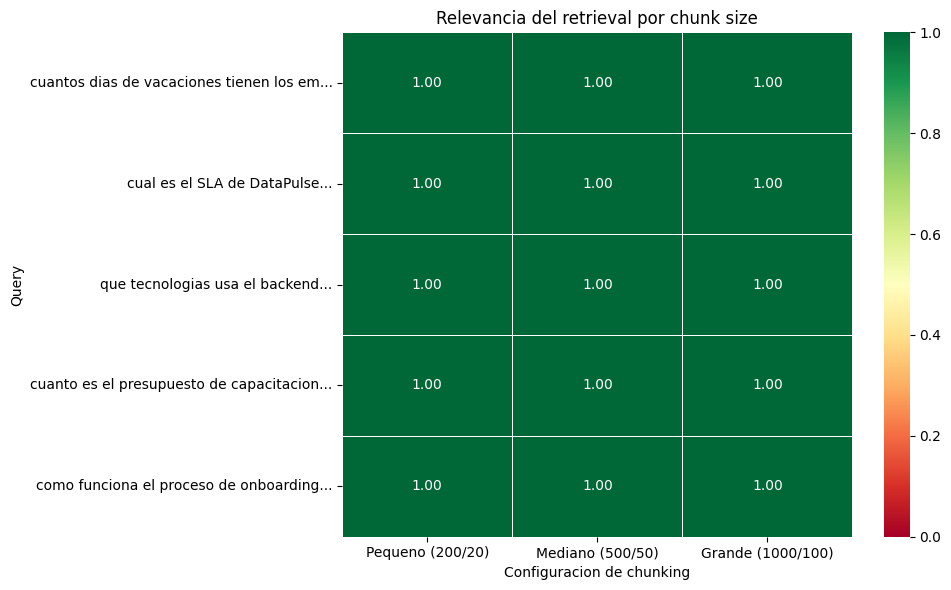


Relevancia promedio por configuracion:
  Pequeno (200/20): 1.00
  Mediano (500/50): 1.00
  Grande (1000/100): 1.00


In [12]:
# Heatmap de relevancia
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(relevance_df, annot=True, fmt='.2f', cmap='RdYlGn',
            vmin=0, vmax=1, linewidths=0.5, ax=ax)
ax.set_title('Relevancia del retrieval por chunk size')
ax.set_ylabel('Query')
ax.set_xlabel('Configuracion de chunking')

plt.tight_layout()
plt.show()

# Promedio por config
print("\nRelevancia promedio por configuracion:")
for col in relevance_df.columns:
    print(f"  {col}: {relevance_df[col].mean():.2f}")

---
## Seccion 4: Almacenamiento Persistente

En produccion, no queremos re-indexar cada vez que reiniciamos la aplicacion. Tanto ChromaDB como FAISS permiten guardar y cargar indices.

### 4.1 ChromaDB persistente

In [13]:
CHROMA_DIR = "./chroma_persist_demo"

# Guardar
chroma_persist = Chroma.from_documents(
    lc_docs,
    embeddings_model,
    persist_directory=CHROMA_DIR,
)
print(f"ChromaDB guardado en: {CHROMA_DIR}")
print(f"Documentos: {chroma_persist._collection.count()}")

# Simular reinicio: cargar desde disco
chroma_loaded = Chroma(
    persist_directory=CHROMA_DIR,
    embedding_function=embeddings_model,
)
print(f"\nChromaDB cargado desde disco")
print(f"Documentos recuperados: {chroma_loaded._collection.count()}")

# Verificar que funciona
test = chroma_loaded.similarity_search("vacaciones", k=1)
print(f"\nQuery test: {test[0].page_content[:80]}...")

ChromaDB guardado en: ./chroma_persist_demo
Documentos: 13

ChromaDB cargado desde disco
Documentos recuperados: 13



Query test: Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo comp...


### 4.2 FAISS persistente

In [14]:
FAISS_DIR = "./faiss_persist_demo"

# Guardar
faiss_store.save_local(FAISS_DIR)
print(f"FAISS guardado en: {FAISS_DIR}")

# Cargar desde disco
faiss_loaded = LangchainFAISS.load_local(
    FAISS_DIR,
    embeddings_model,
    allow_dangerous_deserialization=True,
)
print(f"FAISS cargado desde disco")

# Verificar que funciona
test = faiss_loaded.similarity_search("vacaciones", k=1)
print(f"\nQuery test: {test[0].page_content[:80]}...")

FAISS guardado en: ./faiss_persist_demo
FAISS cargado desde disco



Query test: Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo comp...


---
## Seccion 5: Comparacion de Modelos de Embeddings

Comparemos como diferentes modelos de embeddings capturan la similitud semantica.

In [15]:
# 15 pares de frases con similitud esperada
pares = [
    # Pares muy similares (esperado > 0.8)
    ("El gato duerme en el sofa", "El felino descansa en el sillon"),
    ("Python es un lenguaje de programacion", "Python es un lenguaje para programar"),
    ("Hace mucho calor hoy", "La temperatura esta muy alta"),
    ("El avion despego a las 3 PM", "El vuelo salio a las 15 horas"),
    ("Me duele la cabeza", "Tengo dolor de cabeza"),
    # Pares moderadamente similares (esperado 0.4-0.7)
    ("El perro juega en el parque", "Los ninos corren en el jardin"),
    ("Voy a cocinar pasta", "El restaurante tiene buena comida italiana"),
    ("Estoy aprendiendo machine learning", "Los datos son importantes para la IA"),
    ("El doctor reviso los resultados", "El paciente necesita medicamentos"),
    ("Manana tengo examen", "Necesito estudiar esta noche"),
    # Pares no similares (esperado < 0.3)
    ("El gato duerme en el sofa", "Python es un lenguaje de programacion"),
    ("Hace mucho calor hoy", "La ecuacion tiene dos variables"),
    ("Me gusta el chocolate", "El servidor esta caido"),
    ("El avion despego a las 3 PM", "Las flores necesitan agua"),
    ("Voy a cocinar pasta", "El algoritmo es eficiente"),
]

categorias_pares = (
    ['Similar'] * 5 + ['Moderado'] * 5 + ['Diferente'] * 5
)

print(f"Pares a evaluar: {len(pares)}")

Pares a evaluar: 15


In [16]:
# Calcular similitud con ambos modelos
model_hf = SentenceTransformer('all-MiniLM-L6-v2')

sims_openai = []
sims_hf = []

# OpenAI
all_texts_flat = []
for a, b in pares:
    all_texts_flat.extend([a, b])

resp = client.embeddings.create(input=all_texts_flat, model="text-embedding-3-small")
all_embs_openai = np.array([e.embedding for e in resp.data])

# HuggingFace
all_embs_hf = model_hf.encode(all_texts_flat)

for i in range(len(pares)):
    a_idx = i * 2
    b_idx = i * 2 + 1

    sim_oa = cosine_similarity([all_embs_openai[a_idx]], [all_embs_openai[b_idx]])[0][0]
    sim_hf = cosine_similarity([all_embs_hf[a_idx]], [all_embs_hf[b_idx]])[0][0]

    sims_openai.append(sim_oa)
    sims_hf.append(sim_hf)

# Tabla de resultados
df_sims = pd.DataFrame({
    'Frase A': [p[0][:35] + '...' for p in pares],
    'Frase B': [p[1][:35] + '...' for p in pares],
    'Categoria': categorias_pares,
    'OpenAI': [f"{s:.3f}" for s in sims_openai],
    'HuggingFace': [f"{s:.3f}" for s in sims_hf],
})

print(df_sims.to_string(index=False))

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|          | 1/103 [00:00<00:00, 4951.95it/s, Materializing param=embeddings.LayerNorm.bias]

Loading weights:   1%|          | 1/103 [00:00<00:00, 855.46it/s, Materializing param=embeddings.LayerNorm.bias] 

Loading weights:   2%|▏         | 2/103 [00:00<00:00, 812.69it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   2%|▏         | 2/103 [00:00<00:00, 538.94it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   3%|▎         | 3/103 [00:00<00:00, 615.12it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   3%|▎         | 3/103 [00:00<00:00, 519.93it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   4%|▍         | 4/103 [00:00<00:00, 555.79it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   4%|▍         | 4/103 [00:00<00:00, 531.92it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   5%|▍         | 5/103 [00:00<00:00, 609.25it/s, Materializing param=embeddings.word_embeddings.weight]      

Loading weights:   5%|▍         | 5/103 [00:00<00:00, 557.80it/s, Materializing param=embeddings.word_embeddings.weight]

Loading weights:   6%|▌         | 6/103 [00:00<00:00, 614.76it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|▌         | 6/103 [00:00<00:00, 606.62it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|▋         | 7/103 [00:00<00:00, 691.71it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|▋         | 7/103 [00:00<00:00, 682.13it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|▊         | 8/103 [00:00<00:00, 763.64it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]      

Loading weights:   8%|▊         | 8/103 [00:00<00:00, 754.86it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|▊         | 9/103 [00:00<00:00, 839.18it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|▊         | 9/103 [00:00<00:00, 830.48it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|▉         | 10/103 [00:00<00:00, 911.51it/s, Materializing param=encoder.layer.0.attention.self.key.bias]     

Loading weights:  10%|▉         | 10/103 [00:00<00:00, 902.62it/s, Materializing param=encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|█         | 11/103 [00:00<00:00, 981.96it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|█         | 11/103 [00:00<00:00, 973.38it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█▏        | 12/103 [00:00<00:00, 1046.48it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█▏        | 12/103 [00:00<00:00, 1032.87it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|█▎        | 13/103 [00:00<00:00, 1104.23it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|█▎        | 13/103 [00:00<00:00, 1094.09it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|█▎        | 14/103 [00:00<00:00, 1166.29it/s, Materializing param=encoder.layer.0.attention.self.value.bias]  

Loading weights:  14%|█▎        | 14/103 [00:00<00:00, 1156.94it/s, Materializing param=encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|█▍        | 15/103 [00:00<00:00, 1224.88it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|█▍        | 15/103 [00:00<00:00, 1214.68it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|█▌        | 16/103 [00:00<00:00, 1281.34it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]    

Loading weights:  16%|█▌        | 16/103 [00:00<00:00, 1269.34it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█▋        | 17/103 [00:00<00:00, 1336.07it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█▋        | 17/103 [00:00<00:00, 1322.66it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█▋        | 18/103 [00:00<00:00, 1385.35it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]    

Loading weights:  17%|█▋        | 18/103 [00:00<00:00, 1374.16it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|█▊        | 19/103 [00:00<00:00, 1436.15it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|█▊        | 19/103 [00:00<00:00, 1422.48it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|█▉        | 20/103 [00:00<00:00, 1477.54it/s, Materializing param=encoder.layer.0.output.dense.bias]      

Loading weights:  19%|█▉        | 20/103 [00:00<00:00, 1464.67it/s, Materializing param=encoder.layer.0.output.dense.bias]

Loading weights:  20%|██        | 21/103 [00:00<00:00, 1522.38it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:  20%|██        | 21/103 [00:00<00:00, 1512.76it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:  21%|██▏       | 22/103 [00:00<00:00, 1566.85it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|██▏       | 22/103 [00:00<00:00, 1555.44it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██▏       | 23/103 [00:00<00:00, 1608.75it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██▏       | 23/103 [00:00<00:00, 1594.79it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██▎       | 24/103 [00:00<00:00, 1650.49it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]      

Loading weights:  23%|██▎       | 24/103 [00:00<00:00, 1638.67it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|██▍       | 25/103 [00:00<00:00, 1691.50it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|██▍       | 25/103 [00:00<00:00, 1680.33it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|██▌       | 26/103 [00:00<00:00, 1731.61it/s, Materializing param=encoder.layer.1.attention.self.key.bias]      

Loading weights:  25%|██▌       | 26/103 [00:00<00:00, 1720.25it/s, Materializing param=encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██▌       | 27/103 [00:00<00:00, 1770.74it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██▌       | 27/103 [00:00<00:00, 1757.50it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|██▋       | 28/103 [00:00<00:00, 1807.72it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|██▋       | 28/103 [00:00<00:00, 1797.18it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██▊       | 29/103 [00:00<00:00, 1845.97it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██▊       | 29/103 [00:00<00:00, 1832.32it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|██▉       | 30/103 [00:00<00:00, 1880.40it/s, Materializing param=encoder.layer.1.attention.self.value.bias]  

Loading weights:  29%|██▉       | 30/103 [00:00<00:00, 1868.37it/s, Materializing param=encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███       | 31/103 [00:00<00:00, 1916.20it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███       | 31/103 [00:00<00:00, 1902.79it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|███       | 32/103 [00:00<00:00, 1950.16it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]    

Loading weights:  31%|███       | 32/103 [00:00<00:00, 1930.27it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|███▏      | 33/103 [00:00<00:00, 1975.93it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|███▏      | 33/103 [00:00<00:00, 1963.60it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|███▎      | 34/103 [00:00<00:00, 2006.87it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]    

Loading weights:  33%|███▎      | 34/103 [00:00<00:00, 1993.32it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|███▍      | 35/103 [00:00<00:00, 2038.08it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|███▍      | 35/103 [00:00<00:00, 2025.95it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|███▍      | 36/103 [00:00<00:00, 2068.88it/s, Materializing param=encoder.layer.1.output.dense.bias]      

Loading weights:  35%|███▍      | 36/103 [00:00<00:00, 2058.33it/s, Materializing param=encoder.layer.1.output.dense.bias]

Loading weights:  36%|███▌      | 37/103 [00:00<00:00, 2101.81it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:  36%|███▌      | 37/103 [00:00<00:00, 2087.34it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:  37%|███▋      | 38/103 [00:00<00:00, 2128.26it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|███▋      | 38/103 [00:00<00:00, 2114.40it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|███▊      | 39/103 [00:00<00:00, 2152.82it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|███▊      | 39/103 [00:00<00:00, 2140.74it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|███▉      | 40/103 [00:00<00:00, 2180.56it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]      

Loading weights:  39%|███▉      | 40/103 [00:00<00:00, 2168.72it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|███▉      | 41/103 [00:00<00:00, 2208.35it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|███▉      | 41/103 [00:00<00:00, 2196.05it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|████      | 42/103 [00:00<00:00, 2235.00it/s, Materializing param=encoder.layer.2.attention.self.key.bias]      

Loading weights:  41%|████      | 42/103 [00:00<00:00, 2224.11it/s, Materializing param=encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|████▏     | 43/103 [00:00<00:00, 2261.02it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|████▏     | 43/103 [00:00<00:00, 2250.02it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|████▎     | 44/103 [00:00<00:00, 2287.59it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|████▎     | 44/103 [00:00<00:00, 2276.36it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|████▎     | 45/103 [00:00<00:00, 2313.04it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|████▎     | 45/103 [00:00<00:00, 2293.22it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████▍     | 46/103 [00:00<00:00, 2324.64it/s, Materializing param=encoder.layer.2.attention.self.value.bias]  

Loading weights:  45%|████▍     | 46/103 [00:00<00:00, 2310.77it/s, Materializing param=encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|████▌     | 47/103 [00:00<00:00, 2344.64it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|████▌     | 47/103 [00:00<00:00, 2332.37it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|████▋     | 48/103 [00:00<00:00, 2366.52it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]    

Loading weights:  47%|████▋     | 48/103 [00:00<00:00, 2353.40it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|████▊     | 49/103 [00:00<00:00, 2382.80it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|████▊     | 49/103 [00:00<00:00, 2357.35it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████▊     | 50/103 [00:00<00:00, 2385.62it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]    

Loading weights:  49%|████▊     | 50/103 [00:00<00:00, 2355.82it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|████▉     | 51/103 [00:00<00:00, 2383.21it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|████▉     | 51/103 [00:00<00:00, 2339.11it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████     | 52/103 [00:00<00:00, 2358.82it/s, Materializing param=encoder.layer.2.output.dense.bias]      

Loading weights:  50%|█████     | 52/103 [00:00<00:00, 2345.63it/s, Materializing param=encoder.layer.2.output.dense.bias]

Loading weights:  51%|█████▏    | 53/103 [00:00<00:00, 2371.38it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  51%|█████▏    | 53/103 [00:00<00:00, 2358.50it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  52%|█████▏    | 54/103 [00:00<00:00, 2378.77it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|█████▏    | 54/103 [00:00<00:00, 2365.33it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|█████▎    | 55/103 [00:00<00:00, 2393.09it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|█████▎    | 55/103 [00:00<00:00, 2371.42it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|█████▍    | 56/103 [00:00<00:00, 2399.24it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]      

Loading weights:  54%|█████▍    | 56/103 [00:00<00:00, 2387.66it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████▌    | 57/103 [00:00<00:00, 2415.37it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████▌    | 57/103 [00:00<00:00, 2404.46it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|█████▋    | 58/103 [00:00<00:00, 2432.06it/s, Materializing param=encoder.layer.3.attention.self.key.bias]      

Loading weights:  56%|█████▋    | 58/103 [00:00<00:00, 2422.43it/s, Materializing param=encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|█████▋    | 59/103 [00:00<00:00, 2452.20it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|█████▋    | 59/103 [00:00<00:00, 2440.83it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|█████▊    | 60/103 [00:00<00:00, 2468.52it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|█████▊    | 60/103 [00:00<00:00, 2458.42it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|█████▉    | 61/103 [00:00<00:00, 2486.98it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|█████▉    | 61/103 [00:00<00:00, 2475.86it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|██████    | 62/103 [00:00<00:00, 2504.06it/s, Materializing param=encoder.layer.3.attention.self.value.bias]  

Loading weights:  60%|██████    | 62/103 [00:00<00:00, 2492.57it/s, Materializing param=encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|██████    | 63/103 [00:00<00:00, 2521.12it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|██████    | 63/103 [00:00<00:00, 2509.06it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|██████▏   | 64/103 [00:00<00:00, 2536.96it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]    

Loading weights:  62%|██████▏   | 64/103 [00:00<00:00, 2524.15it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|██████▎   | 65/103 [00:00<00:00, 2550.23it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|██████▎   | 65/103 [00:00<00:00, 2539.37it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|██████▍   | 66/103 [00:00<00:00, 2563.71it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]    

Loading weights:  64%|██████▍   | 66/103 [00:00<00:00, 2552.90it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|██████▌   | 67/103 [00:00<00:00, 2577.51it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|██████▌   | 67/103 [00:00<00:00, 2567.15it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|██████▌   | 68/103 [00:00<00:00, 2592.44it/s, Materializing param=encoder.layer.3.output.dense.bias]      

Loading weights:  66%|██████▌   | 68/103 [00:00<00:00, 2583.71it/s, Materializing param=encoder.layer.3.output.dense.bias]

Loading weights:  67%|██████▋   | 69/103 [00:00<00:00, 2611.95it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  67%|██████▋   | 69/103 [00:00<00:00, 2601.01it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  68%|██████▊   | 70/103 [00:00<00:00, 2625.07it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|██████▊   | 70/103 [00:00<00:00, 2614.58it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|██████▉   | 71/103 [00:00<00:00, 2638.32it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|██████▉   | 71/103 [00:00<00:00, 2628.17it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████▉   | 72/103 [00:00<00:00, 2652.83it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]      

Loading weights:  70%|██████▉   | 72/103 [00:00<00:00, 2642.10it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████   | 73/103 [00:00<00:00, 2665.81it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████   | 73/103 [00:00<00:00, 2656.86it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|███████▏  | 74/103 [00:00<00:00, 2681.36it/s, Materializing param=encoder.layer.4.attention.self.key.bias]      

Loading weights:  72%|███████▏  | 74/103 [00:00<00:00, 2671.49it/s, Materializing param=encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████▎  | 75/103 [00:00<00:00, 2693.40it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████▎  | 75/103 [00:00<00:00, 2683.47it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|███████▍  | 76/103 [00:00<00:00, 2708.69it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|███████▍  | 76/103 [00:00<00:00, 2696.57it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|███████▍  | 77/103 [00:00<00:00, 2718.46it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|███████▍  | 77/103 [00:00<00:00, 2706.23it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|███████▌  | 78/103 [00:00<00:00, 2729.76it/s, Materializing param=encoder.layer.4.attention.self.value.bias]  

Loading weights:  76%|███████▌  | 78/103 [00:00<00:00, 2712.28it/s, Materializing param=encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████▋  | 79/103 [00:00<00:00, 2736.33it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████▋  | 79/103 [00:00<00:00, 2726.69it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|███████▊  | 80/103 [00:00<00:00, 2748.97it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]    

Loading weights:  78%|███████▊  | 80/103 [00:00<00:00, 2739.83it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|███████▊  | 81/103 [00:00<00:00, 2762.06it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|███████▊  | 81/103 [00:00<00:00, 2753.06it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████▉  | 82/103 [00:00<00:00, 2775.24it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]    

Loading weights:  80%|███████▉  | 82/103 [00:00<00:00, 2765.51it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████  | 83/103 [00:00<00:00, 2787.85it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████  | 83/103 [00:00<00:00, 2778.62it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████▏ | 84/103 [00:00<00:00, 2800.36it/s, Materializing param=encoder.layer.4.output.dense.bias]      

Loading weights:  82%|████████▏ | 84/103 [00:00<00:00, 2791.33it/s, Materializing param=encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████▎ | 85/103 [00:00<00:00, 2813.57it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████▎ | 85/103 [00:00<00:00, 2804.72it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████▎ | 86/103 [00:00<00:00, 2825.42it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|████████▎ | 86/103 [00:00<00:00, 2814.88it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|████████▍ | 87/103 [00:00<00:00, 2836.37it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|████████▍ | 87/103 [00:00<00:00, 2827.34it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|████████▌ | 88/103 [00:00<00:00, 2849.11it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]      

Loading weights:  85%|████████▌ | 88/103 [00:00<00:00, 2834.51it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|████████▋ | 89/103 [00:00<00:00, 2855.23it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|████████▋ | 89/103 [00:00<00:00, 2845.29it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|████████▋ | 90/103 [00:00<00:00, 2866.62it/s, Materializing param=encoder.layer.5.attention.self.key.bias]      

Loading weights:  87%|████████▋ | 90/103 [00:00<00:00, 2857.22it/s, Materializing param=encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|████████▊ | 91/103 [00:00<00:00, 2879.10it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|████████▊ | 91/103 [00:00<00:00, 2863.97it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|████████▉ | 92/103 [00:00<00:00, 2885.72it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|████████▉ | 92/103 [00:00<00:00, 2878.06it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████ | 93/103 [00:00<00:00, 2897.82it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████ | 93/103 [00:00<00:00, 2889.82it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████▏| 94/103 [00:00<00:00, 2907.79it/s, Materializing param=encoder.layer.5.attention.self.value.bias]  

Loading weights:  91%|█████████▏| 94/103 [00:00<00:00, 2900.18it/s, Materializing param=encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|█████████▏| 95/103 [00:00<00:00, 2919.78it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|█████████▏| 95/103 [00:00<00:00, 2911.43it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|█████████▎| 96/103 [00:00<00:00, 2931.93it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]    

Loading weights:  93%|█████████▎| 96/103 [00:00<00:00, 2922.90it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████▍| 97/103 [00:00<00:00, 2942.63it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████▍| 97/103 [00:00<00:00, 2934.33it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|█████████▌| 98/103 [00:00<00:00, 2954.67it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]    

Loading weights:  95%|█████████▌| 98/103 [00:00<00:00, 2947.02it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|█████████▌| 99/103 [00:00<00:00, 2967.88it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|█████████▌| 99/103 [00:00<00:00, 2959.46it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|█████████▋| 100/103 [00:00<00:00, 2980.18it/s, Materializing param=encoder.layer.5.output.dense.bias]     

Loading weights:  97%|█████████▋| 100/103 [00:00<00:00, 2971.50it/s, Materializing param=encoder.layer.5.output.dense.bias]

Loading weights:  98%|█████████▊| 101/103 [00:00<00:00, 2991.62it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  98%|█████████▊| 101/103 [00:00<00:00, 2983.59it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  99%|█████████▉| 102/103 [00:00<00:00, 3003.44it/s, Materializing param=pooler.dense.bias]                  

Loading weights:  99%|█████████▉| 102/103 [00:00<00:00, 2994.99it/s, Materializing param=pooler.dense.bias]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 3011.72it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 3001.43it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2984.98it/s, Materializing param=pooler.dense.weight]


BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


                               Frase A                                Frase B Categoria OpenAI HuggingFace
          El gato duerme en el sofa...     El felino descansa en el sillon...   Similar  0.790       0.525
Python es un lenguaje de programaci... Python es un lenguaje para programa...   Similar  0.929       0.896
               Hace mucho calor hoy...        La temperatura esta muy alta...   Similar  0.688       0.342
        El avion despego a las 3 PM...       El vuelo salio a las 15 horas...   Similar  0.651       0.673
                 Me duele la cabeza...               Tengo dolor de cabeza...   Similar  0.817       0.671
        El perro juega en el parque...       Los ninos corren en el jardin...  Moderado  0.459       0.395
                Voy a cocinar pasta... El restaurante tiene buena comida i...  Moderado  0.395       0.477
 Estoy aprendiendo machine learning... Los datos son importantes para la I...  Moderado  0.431       0.241
    El doctor reviso los resultados..

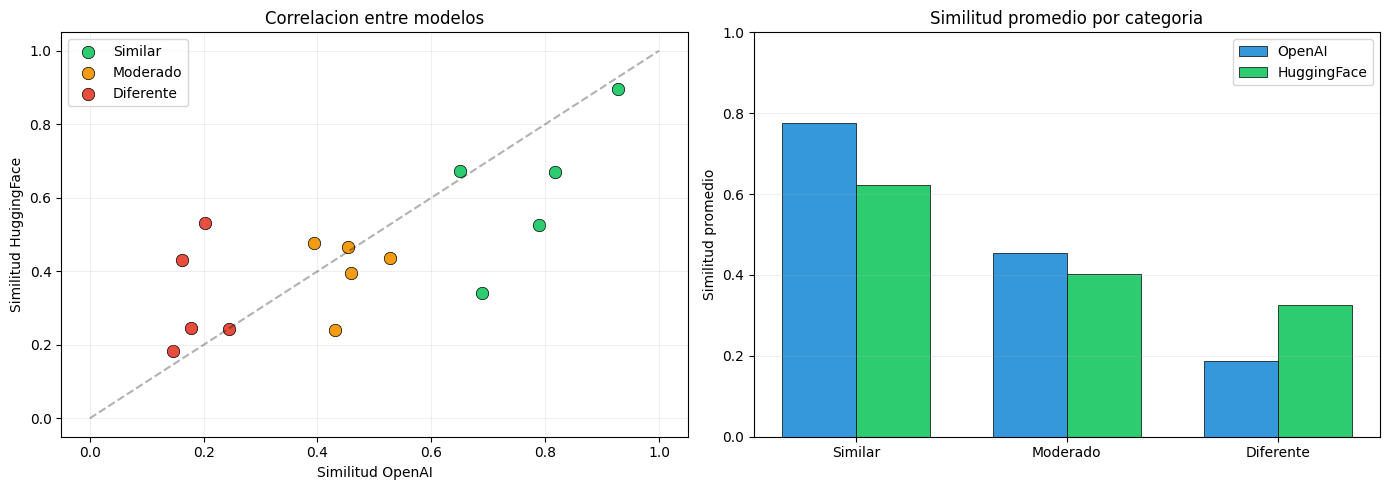

In [17]:
# Scatter de correlacion entre modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
color_map = {'Similar': '#2ecc71', 'Moderado': '#f39c12', 'Diferente': '#e74c3c'}
for cat in ['Similar', 'Moderado', 'Diferente']:
    mask = [c == cat for c in categorias_pares]
    x = [sims_openai[i] for i, m in enumerate(mask) if m]
    y = [sims_hf[i] for i, m in enumerate(mask) if m]
    axes[0].scatter(x, y, c=color_map[cat], label=cat, s=80, edgecolors='black', linewidth=0.5)

# Linea diagonal (correlacion perfecta)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].set_xlabel('Similitud OpenAI')
axes[0].set_ylabel('Similitud HuggingFace')
axes[0].set_title('Correlacion entre modelos')
axes[0].legend()
axes[0].grid(True, alpha=0.2)

# Barras comparativas por categoria
cats = ['Similar', 'Moderado', 'Diferente']
avg_oa = [np.mean([sims_openai[i] for i, c in enumerate(categorias_pares) if c == cat]) for cat in cats]
avg_hf = [np.mean([sims_hf[i] for i, c in enumerate(categorias_pares) if c == cat]) for cat in cats]

x = np.arange(len(cats))
width = 0.35
axes[1].bar(x - width/2, avg_oa, width, label='OpenAI', color='#3498db', edgecolor='black', linewidth=0.5)
axes[1].bar(x + width/2, avg_hf, width, label='HuggingFace', color='#2ecc71', edgecolor='black', linewidth=0.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(cats)
axes[1].set_ylabel('Similitud promedio')
axes[1].set_title('Similitud promedio por categoria')
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.2, axis='y')

plt.tight_layout()
plt.show()

In [18]:
# Retrieval comparison: mismos documentos, mismos queries, diferentes embeddings
from langchain_community.embeddings import HuggingFaceEmbeddings

hf_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Crear stores con cada modelo
faiss_openai = LangchainFAISS.from_documents(lc_docs, embeddings_model)
faiss_hf = LangchainFAISS.from_documents(lc_docs, hf_embeddings)

retrieval_queries = [
    "cuantos dias de vacaciones hay",
    "como es el stack tecnologico",
    "que es DataPulse",
]

print("Comparacion de retrieval: OpenAI vs HuggingFace")
print("=" * 60)
for q in retrieval_queries:
    r_oa = faiss_openai.similarity_search(q, k=1)
    r_hf = faiss_hf.similarity_search(q, k=1)

    print(f"\nQuery: '{q}'")
    print(f"  OpenAI:      {r_oa[0].page_content[:80]}...")
    print(f"  HuggingFace: {r_hf[0].page_content[:80]}...")
    match = r_oa[0].page_content[:80] == r_hf[0].page_content[:80]
    print(f"  Mismo top-1: {'SI' if match else 'NO'}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|          | 1/103 [00:00<00:00, 25575.02it/s, Materializing param=embeddings.LayerNorm.bias]

Loading weights:   1%|          | 1/103 [00:00<00:00, 998.88it/s, Materializing param=embeddings.LayerNorm.bias]  

Loading weights:   2%|▏         | 2/103 [00:00<00:00, 927.23it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   2%|▏         | 2/103 [00:00<00:00, 722.78it/s, Materializing param=embeddings.LayerNorm.weight]

Loading weights:   3%|▎         | 3/103 [00:00<00:00, 868.75it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   3%|▎         | 3/103 [00:00<00:00, 740.21it/s, Materializing param=embeddings.position_embeddings.weight]

Loading weights:   4%|▍         | 4/103 [00:00<00:00, 804.66it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   4%|▍         | 4/103 [00:00<00:00, 737.04it/s, Materializing param=embeddings.token_type_embeddings.weight]

Loading weights:   5%|▍         | 5/103 [00:00<00:00, 833.89it/s, Materializing param=embeddings.word_embeddings.weight]      

Loading weights:   5%|▍         | 5/103 [00:00<00:00, 712.15it/s, Materializing param=embeddings.word_embeddings.weight]

Loading weights:   6%|▌         | 6/103 [00:00<00:00, 801.59it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|▌         | 6/103 [00:00<00:00, 741.28it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|▋         | 7/103 [00:00<00:00, 776.05it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|▋         | 7/103 [00:00<00:00, 747.61it/s, Materializing param=encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|▊         | 8/103 [00:00<00:00, 826.97it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]      

Loading weights:   8%|▊         | 8/103 [00:00<00:00, 807.18it/s, Materializing param=encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|▊         | 9/103 [00:00<00:00, 884.36it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|▊         | 9/103 [00:00<00:00, 868.21it/s, Materializing param=encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|▉         | 10/103 [00:00<00:00, 923.27it/s, Materializing param=encoder.layer.0.attention.self.key.bias]     

Loading weights:  10%|▉         | 10/103 [00:00<00:00, 909.91it/s, Materializing param=encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|█         | 11/103 [00:00<00:00, 980.92it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|█         | 11/103 [00:00<00:00, 963.56it/s, Materializing param=encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█▏        | 12/103 [00:00<00:00, 1028.02it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█▏        | 12/103 [00:00<00:00, 1004.76it/s, Materializing param=encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|█▎        | 13/103 [00:00<00:00, 1065.23it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|█▎        | 13/103 [00:00<00:00, 1047.97it/s, Materializing param=encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|█▎        | 14/103 [00:00<00:00, 1106.09it/s, Materializing param=encoder.layer.0.attention.self.value.bias]  

Loading weights:  14%|█▎        | 14/103 [00:00<00:00, 1090.00it/s, Materializing param=encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|█▍        | 15/103 [00:00<00:00, 1145.73it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|█▍        | 15/103 [00:00<00:00, 1121.07it/s, Materializing param=encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|█▌        | 16/103 [00:00<00:00, 1172.25it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]    

Loading weights:  16%|█▌        | 16/103 [00:00<00:00, 1147.45it/s, Materializing param=encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█▋        | 17/103 [00:00<00:00, 1192.82it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█▋        | 17/103 [00:00<00:00, 1176.29it/s, Materializing param=encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█▋        | 18/103 [00:00<00:00, 1224.16it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]    

Loading weights:  17%|█▋        | 18/103 [00:00<00:00, 1207.48it/s, Materializing param=encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|█▊        | 19/103 [00:00<00:00, 1255.86it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|█▊        | 19/103 [00:00<00:00, 1239.39it/s, Materializing param=encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|█▉        | 20/103 [00:00<00:00, 1285.93it/s, Materializing param=encoder.layer.0.output.dense.bias]      

Loading weights:  19%|█▉        | 20/103 [00:00<00:00, 1254.93it/s, Materializing param=encoder.layer.0.output.dense.bias]

Loading weights:  20%|██        | 21/103 [00:00<00:00, 1295.49it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:  20%|██        | 21/103 [00:00<00:00, 1276.12it/s, Materializing param=encoder.layer.0.output.dense.weight]

Loading weights:  21%|██▏       | 22/103 [00:00<00:00, 1318.30it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|██▏       | 22/103 [00:00<00:00, 1297.40it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██▏       | 23/103 [00:00<00:00, 1331.64it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██▏       | 23/103 [00:00<00:00, 1315.71it/s, Materializing param=encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██▎       | 24/103 [00:00<00:00, 1355.48it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]      

Loading weights:  23%|██▎       | 24/103 [00:00<00:00, 1342.88it/s, Materializing param=encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|██▍       | 25/103 [00:00<00:00, 1383.97it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|██▍       | 25/103 [00:00<00:00, 1365.08it/s, Materializing param=encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|██▌       | 26/103 [00:00<00:00, 1386.14it/s, Materializing param=encoder.layer.1.attention.self.key.bias]      

Loading weights:  25%|██▌       | 26/103 [00:00<00:00, 1359.12it/s, Materializing param=encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██▌       | 27/103 [00:00<00:00, 1389.37it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██▌       | 27/103 [00:00<00:00, 1366.95it/s, Materializing param=encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|██▋       | 28/103 [00:00<00:00, 1378.49it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|██▋       | 28/103 [00:00<00:00, 1366.72it/s, Materializing param=encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██▊       | 29/103 [00:00<00:00, 1394.56it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██▊       | 29/103 [00:00<00:00, 1384.05it/s, Materializing param=encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|██▉       | 30/103 [00:00<00:00, 1417.70it/s, Materializing param=encoder.layer.1.attention.self.value.bias]  

Loading weights:  29%|██▉       | 30/103 [00:00<00:00, 1407.72it/s, Materializing param=encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███       | 31/103 [00:00<00:00, 1440.86it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███       | 31/103 [00:00<00:00, 1429.57it/s, Materializing param=encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|███       | 32/103 [00:00<00:00, 1461.78it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]    

Loading weights:  31%|███       | 32/103 [00:00<00:00, 1443.98it/s, Materializing param=encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|███▏      | 33/103 [00:00<00:00, 1476.17it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|███▏      | 33/103 [00:00<00:00, 1464.32it/s, Materializing param=encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|███▎      | 34/103 [00:00<00:00, 1495.56it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]    

Loading weights:  33%|███▎      | 34/103 [00:00<00:00, 1486.66it/s, Materializing param=encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|███▍      | 35/103 [00:00<00:00, 1514.24it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|███▍      | 35/103 [00:00<00:00, 1504.86it/s, Materializing param=encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|███▍      | 36/103 [00:00<00:00, 1535.05it/s, Materializing param=encoder.layer.1.output.dense.bias]      

Loading weights:  35%|███▍      | 36/103 [00:00<00:00, 1524.06it/s, Materializing param=encoder.layer.1.output.dense.bias]

Loading weights:  36%|███▌      | 37/103 [00:00<00:00, 1554.35it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:  36%|███▌      | 37/103 [00:00<00:00, 1545.14it/s, Materializing param=encoder.layer.1.output.dense.weight]

Loading weights:  37%|███▋      | 38/103 [00:00<00:00, 1575.12it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|███▋      | 38/103 [00:00<00:00, 1564.87it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|███▊      | 39/103 [00:00<00:00, 1593.66it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|███▊      | 39/103 [00:00<00:00, 1583.17it/s, Materializing param=encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|███▉      | 40/103 [00:00<00:00, 1612.19it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]      

Loading weights:  39%|███▉      | 40/103 [00:00<00:00, 1601.74it/s, Materializing param=encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|███▉      | 41/103 [00:00<00:00, 1625.12it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|███▉      | 41/103 [00:00<00:00, 1611.82it/s, Materializing param=encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|████      | 42/103 [00:00<00:00, 1638.32it/s, Materializing param=encoder.layer.2.attention.self.key.bias]      

Loading weights:  41%|████      | 42/103 [00:00<00:00, 1628.86it/s, Materializing param=encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|████▏     | 43/103 [00:00<00:00, 1655.04it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|████▏     | 43/103 [00:00<00:00, 1640.59it/s, Materializing param=encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|████▎     | 44/103 [00:00<00:00, 1666.41it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|████▎     | 44/103 [00:00<00:00, 1657.37it/s, Materializing param=encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|████▎     | 45/103 [00:00<00:00, 1683.56it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|████▎     | 45/103 [00:00<00:00, 1674.28it/s, Materializing param=encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████▍     | 46/103 [00:00<00:00, 1698.73it/s, Materializing param=encoder.layer.2.attention.self.value.bias]  

Loading weights:  45%|████▍     | 46/103 [00:00<00:00, 1689.00it/s, Materializing param=encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|████▌     | 47/103 [00:00<00:00, 1714.70it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|████▌     | 47/103 [00:00<00:00, 1706.73it/s, Materializing param=encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|████▋     | 48/103 [00:00<00:00, 1731.48it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]    

Loading weights:  47%|████▋     | 48/103 [00:00<00:00, 1721.42it/s, Materializing param=encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|████▊     | 49/103 [00:00<00:00, 1744.94it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|████▊     | 49/103 [00:00<00:00, 1728.77it/s, Materializing param=encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████▊     | 50/103 [00:00<00:00, 1751.63it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]    

Loading weights:  49%|████▊     | 50/103 [00:00<00:00, 1742.02it/s, Materializing param=encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|████▉     | 51/103 [00:00<00:00, 1765.38it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|████▉     | 51/103 [00:00<00:00, 1756.38it/s, Materializing param=encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████     | 52/103 [00:00<00:00, 1775.40it/s, Materializing param=encoder.layer.2.output.dense.bias]      

Loading weights:  50%|█████     | 52/103 [00:00<00:00, 1767.38it/s, Materializing param=encoder.layer.2.output.dense.bias]

Loading weights:  51%|█████▏    | 53/103 [00:00<00:00, 1792.18it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  51%|█████▏    | 53/103 [00:00<00:00, 1783.49it/s, Materializing param=encoder.layer.2.output.dense.weight]

Loading weights:  52%|█████▏    | 54/103 [00:00<00:00, 1806.09it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|█████▏    | 54/103 [00:00<00:00, 1797.84it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|█████▎    | 55/103 [00:00<00:00, 1820.77it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|█████▎    | 55/103 [00:00<00:00, 1812.31it/s, Materializing param=encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|█████▍    | 56/103 [00:00<00:00, 1834.55it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]      

Loading weights:  54%|█████▍    | 56/103 [00:00<00:00, 1822.68it/s, Materializing param=encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████▌    | 57/103 [00:00<00:00, 1843.52it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████▌    | 57/103 [00:00<00:00, 1835.79it/s, Materializing param=encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|█████▋    | 58/103 [00:00<00:00, 1858.25it/s, Materializing param=encoder.layer.3.attention.self.key.bias]      

Loading weights:  56%|█████▋    | 58/103 [00:00<00:00, 1849.96it/s, Materializing param=encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|█████▋    | 59/103 [00:00<00:00, 1870.46it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|█████▋    | 59/103 [00:00<00:00, 1862.20it/s, Materializing param=encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|█████▊    | 60/103 [00:00<00:00, 1882.47it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|█████▊    | 60/103 [00:00<00:00, 1870.79it/s, Materializing param=encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|█████▉    | 61/103 [00:00<00:00, 1890.23it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|█████▉    | 61/103 [00:00<00:00, 1881.85it/s, Materializing param=encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|██████    | 62/103 [00:00<00:00, 1902.03it/s, Materializing param=encoder.layer.3.attention.self.value.bias]  

Loading weights:  60%|██████    | 62/103 [00:00<00:00, 1894.05it/s, Materializing param=encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|██████    | 63/103 [00:00<00:00, 1913.72it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|██████    | 63/103 [00:00<00:00, 1905.75it/s, Materializing param=encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|██████▏   | 64/103 [00:00<00:00, 1926.37it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]    

Loading weights:  62%|██████▏   | 64/103 [00:00<00:00, 1918.92it/s, Materializing param=encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|██████▎   | 65/103 [00:00<00:00, 1939.20it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|██████▎   | 65/103 [00:00<00:00, 1930.85it/s, Materializing param=encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|██████▍   | 66/103 [00:00<00:00, 1951.16it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]    

Loading weights:  64%|██████▍   | 66/103 [00:00<00:00, 1943.17it/s, Materializing param=encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|██████▌   | 67/103 [00:00<00:00, 1962.73it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|██████▌   | 67/103 [00:00<00:00, 1955.01it/s, Materializing param=encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|██████▌   | 68/103 [00:00<00:00, 1974.16it/s, Materializing param=encoder.layer.3.output.dense.bias]      

Loading weights:  66%|██████▌   | 68/103 [00:00<00:00, 1964.41it/s, Materializing param=encoder.layer.3.output.dense.bias]

Loading weights:  67%|██████▋   | 69/103 [00:00<00:00, 1984.07it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  67%|██████▋   | 69/103 [00:00<00:00, 1975.43it/s, Materializing param=encoder.layer.3.output.dense.weight]

Loading weights:  68%|██████▊   | 70/103 [00:00<00:00, 1994.53it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|██████▊   | 70/103 [00:00<00:00, 1982.61it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|██████▉   | 71/103 [00:00<00:00, 2001.46it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|██████▉   | 71/103 [00:00<00:00, 1993.26it/s, Materializing param=encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████▉   | 72/103 [00:00<00:00, 2011.96it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]      

Loading weights:  70%|██████▉   | 72/103 [00:00<00:00, 2004.51it/s, Materializing param=encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████   | 73/103 [00:00<00:00, 2023.05it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████   | 73/103 [00:00<00:00, 2016.63it/s, Materializing param=encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|███████▏  | 74/103 [00:00<00:00, 2035.26it/s, Materializing param=encoder.layer.4.attention.self.key.bias]      

Loading weights:  72%|███████▏  | 74/103 [00:00<00:00, 2024.41it/s, Materializing param=encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████▎  | 75/103 [00:00<00:00, 2039.82it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████▎  | 75/103 [00:00<00:00, 2032.57it/s, Materializing param=encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|███████▍  | 76/103 [00:00<00:00, 2050.40it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|███████▍  | 76/103 [00:00<00:00, 2044.05it/s, Materializing param=encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|███████▍  | 77/103 [00:00<00:00, 2062.62it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|███████▍  | 77/103 [00:00<00:00, 2055.63it/s, Materializing param=encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|███████▌  | 78/103 [00:00<00:00, 2072.98it/s, Materializing param=encoder.layer.4.attention.self.value.bias]  

Loading weights:  76%|███████▌  | 78/103 [00:00<00:00, 2065.74it/s, Materializing param=encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████▋  | 79/103 [00:00<00:00, 2083.16it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████▋  | 79/103 [00:00<00:00, 2071.53it/s, Materializing param=encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|███████▊  | 80/103 [00:00<00:00, 2087.73it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]    

Loading weights:  78%|███████▊  | 80/103 [00:00<00:00, 2080.19it/s, Materializing param=encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|███████▊  | 81/103 [00:00<00:00, 2093.62it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|███████▊  | 81/103 [00:00<00:00, 2087.42it/s, Materializing param=encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████▉  | 82/103 [00:00<00:00, 2104.99it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]    

Loading weights:  80%|███████▉  | 82/103 [00:00<00:00, 2098.37it/s, Materializing param=encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████  | 83/103 [00:00<00:00, 2116.11it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████  | 83/103 [00:00<00:00, 2109.54it/s, Materializing param=encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████▏ | 84/103 [00:00<00:00, 2127.33it/s, Materializing param=encoder.layer.4.output.dense.bias]      

Loading weights:  82%|████████▏ | 84/103 [00:00<00:00, 2119.61it/s, Materializing param=encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████▎ | 85/103 [00:00<00:00, 2134.49it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████▎ | 85/103 [00:00<00:00, 2126.65it/s, Materializing param=encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████▎ | 86/103 [00:00<00:00, 2143.09it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|████████▎ | 86/103 [00:00<00:00, 2136.23it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|████████▍ | 87/103 [00:00<00:00, 2152.98it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|████████▍ | 87/103 [00:00<00:00, 2145.18it/s, Materializing param=encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|████████▌ | 88/103 [00:00<00:00, 2158.35it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]      

Loading weights:  85%|████████▌ | 88/103 [00:00<00:00, 2149.80it/s, Materializing param=encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|████████▋ | 89/103 [00:00<00:00, 2160.14it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|████████▋ | 89/103 [00:00<00:00, 2151.89it/s, Materializing param=encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|████████▋ | 90/103 [00:00<00:00, 2167.79it/s, Materializing param=encoder.layer.5.attention.self.key.bias]      

Loading weights:  87%|████████▋ | 90/103 [00:00<00:00, 2161.95it/s, Materializing param=encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|████████▊ | 91/103 [00:00<00:00, 2177.08it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|████████▊ | 91/103 [00:00<00:00, 2170.38it/s, Materializing param=encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|████████▉ | 92/103 [00:00<00:00, 2186.15it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|████████▉ | 92/103 [00:00<00:00, 2180.04it/s, Materializing param=encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████ | 93/103 [00:00<00:00, 2197.18it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████ | 93/103 [00:00<00:00, 2191.80it/s, Materializing param=encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████▏| 94/103 [00:00<00:00, 2207.70it/s, Materializing param=encoder.layer.5.attention.self.value.bias]  

Loading weights:  91%|█████████▏| 94/103 [00:00<00:00, 2198.73it/s, Materializing param=encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|█████████▏| 95/103 [00:00<00:00, 2212.49it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|█████████▏| 95/103 [00:00<00:00, 2206.64it/s, Materializing param=encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|█████████▎| 96/103 [00:00<00:00, 2222.93it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]    

Loading weights:  93%|█████████▎| 96/103 [00:00<00:00, 2218.06it/s, Materializing param=encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████▍| 97/103 [00:00<00:00, 2233.47it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████▍| 97/103 [00:00<00:00, 2227.23it/s, Materializing param=encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|█████████▌| 98/103 [00:00<00:00, 2242.25it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]    

Loading weights:  95%|█████████▌| 98/103 [00:00<00:00, 2231.93it/s, Materializing param=encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|█████████▌| 99/103 [00:00<00:00, 2247.03it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|█████████▌| 99/103 [00:00<00:00, 2240.28it/s, Materializing param=encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|█████████▋| 100/103 [00:00<00:00, 2255.55it/s, Materializing param=encoder.layer.5.output.dense.bias]     

Loading weights:  97%|█████████▋| 100/103 [00:00<00:00, 2243.96it/s, Materializing param=encoder.layer.5.output.dense.bias]

Loading weights:  98%|█████████▊| 101/103 [00:00<00:00, 2256.02it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  98%|█████████▊| 101/103 [00:00<00:00, 2245.84it/s, Materializing param=encoder.layer.5.output.dense.weight]

Loading weights:  99%|█████████▉| 102/103 [00:00<00:00, 2260.39it/s, Materializing param=pooler.dense.bias]                  

Loading weights:  99%|█████████▉| 102/103 [00:00<00:00, 2254.09it/s, Materializing param=pooler.dense.bias]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2268.57it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2262.69it/s, Materializing param=pooler.dense.weight]

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2254.66it/s, Materializing param=pooler.dense.weight]


BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Comparacion de retrieval: OpenAI vs HuggingFace



Query: 'cuantos dias de vacaciones hay'
  OpenAI:      Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo comp...
  HuggingFace: Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo comp...
  Mismo top-1: SI



Query: 'como es el stack tecnologico'
  OpenAI:      Stack Tecnologico de NovaTech Solutions. Backend: FastAPI 0.109 sobre Python 3.1...
  HuggingFace: Proceso de Desarrollo en NovaTech. Usamos Scrum con sprints de 2 semanas. Cada e...
  Mismo top-1: NO



Query: 'que es DataPulse'
  OpenAI:      DataPulse - Producto Principal de NovaTech Solutions. DataPulse es una plataform...
  HuggingFace: DataPulse - Producto Principal de NovaTech Solutions. DataPulse es una plataform...
  Mismo top-1: SI


---
## Seccion 6: Rendimiento

Midamos las diferencias de rendimiento entre FAISS y ChromaDB en tres dimensiones:
1. Velocidad de indexado
2. Velocidad de busqueda
3. Uso de memoria

In [19]:
# Pre-generar embeddings para aislar el benchmarking del modelo
resp = client.embeddings.create(input=novatech_docs, model="text-embedding-3-small")
bench_embeddings = np.array([e.embedding for e in resp.data], dtype=np.float32)

dimension = bench_embeddings.shape[1]
n_docs = bench_embeddings.shape[0]

# -- Indexing speed --
# FAISS
start = time.perf_counter()
idx_faiss = faiss.IndexFlatL2(dimension)
idx_faiss.add(bench_embeddings)
time_faiss_index = time.perf_counter() - start

# ChromaDB
start = time.perf_counter()
chroma_bench = chromadb.Client()
col_bench = chroma_bench.create_collection(name="bench")
col_bench.add(
    ids=[f"doc_{i}" for i in range(n_docs)],
    embeddings=bench_embeddings.tolist(),
    documents=novatech_docs,
)
time_chroma_index = time.perf_counter() - start

print("Velocidad de indexado:")
print(f"  FAISS:    {time_faiss_index*1000:.2f} ms")
print(f"  ChromaDB: {time_chroma_index*1000:.2f} ms")

Velocidad de indexado:
  FAISS:    0.21 ms
  ChromaDB: 20.64 ms


In [20]:
# -- Query speed --
query_text = "stack tecnologico del backend"
q_resp = client.embeddings.create(input=[query_text], model="text-embedding-3-small")
q_emb = np.array([q_resp.data[0].embedding], dtype=np.float32)

n_queries = 10

# FAISS
start = time.perf_counter()
for _ in range(n_queries):
    idx_faiss.search(q_emb, k=3)
time_faiss_query = (time.perf_counter() - start) / n_queries

# ChromaDB
start = time.perf_counter()
for _ in range(n_queries):
    col_bench.query(query_embeddings=q_emb.tolist(), n_results=3)
time_chroma_query = (time.perf_counter() - start) / n_queries

print("Velocidad de query (promedio de 10 queries):")
print(f"  FAISS:    {time_faiss_query*1000:.3f} ms")
print(f"  ChromaDB: {time_chroma_query*1000:.3f} ms")

Velocidad de query (promedio de 10 queries):
  FAISS:    0.033 ms
  ChromaDB: 1.287 ms


In [21]:
# -- Memoria estimada --
mem_faiss = bench_embeddings.nbytes / 1024  # KB
# ChromaDB almacena internamente, estimamos similar
mem_chroma = mem_faiss * 1.3  # overhead estimado del 30%

print("Memoria estimada (solo embeddings):")
print(f"  FAISS:    {mem_faiss:.1f} KB")
print(f"  ChromaDB: {mem_chroma:.1f} KB (estimado con overhead)")

Memoria estimada (solo embeddings):
  FAISS:    78.0 KB
  ChromaDB: 101.4 KB (estimado con overhead)


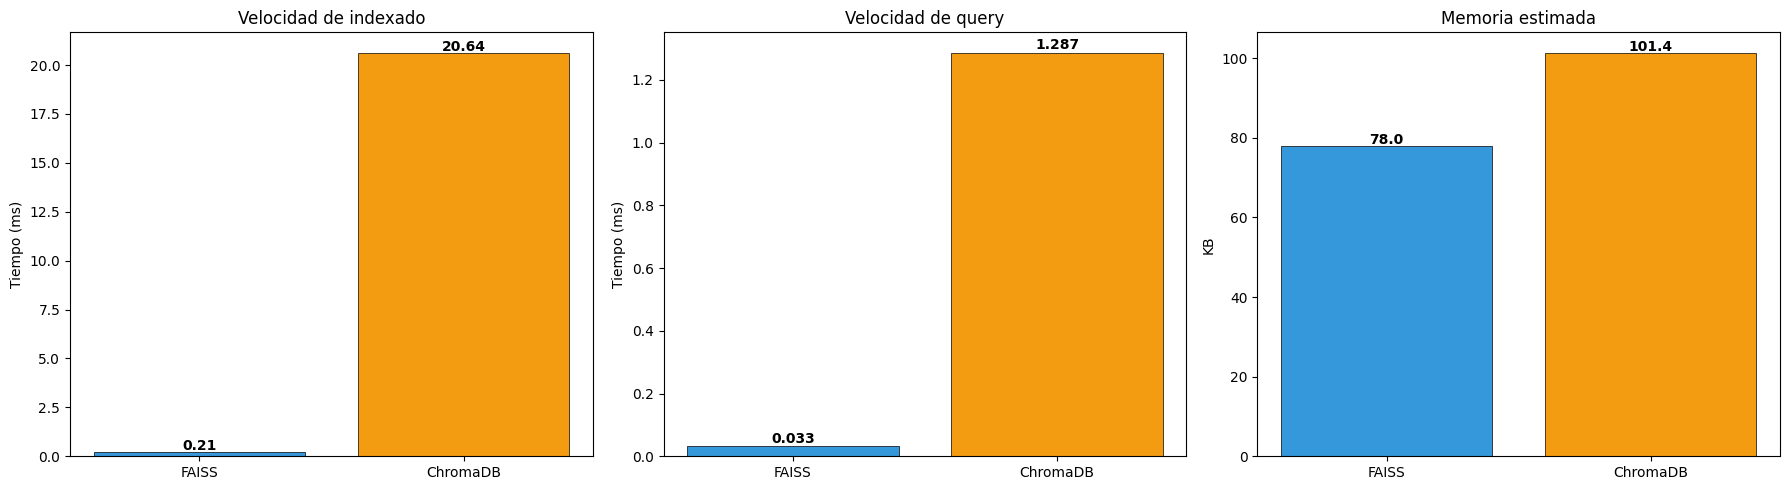

In [22]:
# Grafico de 3 paneles
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

engines = ['FAISS', 'ChromaDB']
colors_bench = ['#3498db', '#f39c12']

# Indexing
axes[0].bar(engines, [time_faiss_index*1000, time_chroma_index*1000],
            color=colors_bench, edgecolor='black', linewidth=0.5)
axes[0].set_title('Velocidad de indexado')
axes[0].set_ylabel('Tiempo (ms)')
for i, v in enumerate([time_faiss_index*1000, time_chroma_index*1000]):
    axes[0].text(i, v + 0.1, f"{v:.2f}", ha='center', fontweight='bold')

# Query
axes[1].bar(engines, [time_faiss_query*1000, time_chroma_query*1000],
            color=colors_bench, edgecolor='black', linewidth=0.5)
axes[1].set_title('Velocidad de query')
axes[1].set_ylabel('Tiempo (ms)')
for i, v in enumerate([time_faiss_query*1000, time_chroma_query*1000]):
    axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')

# Memory
axes[2].bar(engines, [mem_faiss, mem_chroma],
            color=colors_bench, edgecolor='black', linewidth=0.5)
axes[2].set_title('Memoria estimada')
axes[2].set_ylabel('KB')
for i, v in enumerate([mem_faiss, mem_chroma]):
    axes[2].text(i, v + 0.5, f"{v:.1f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

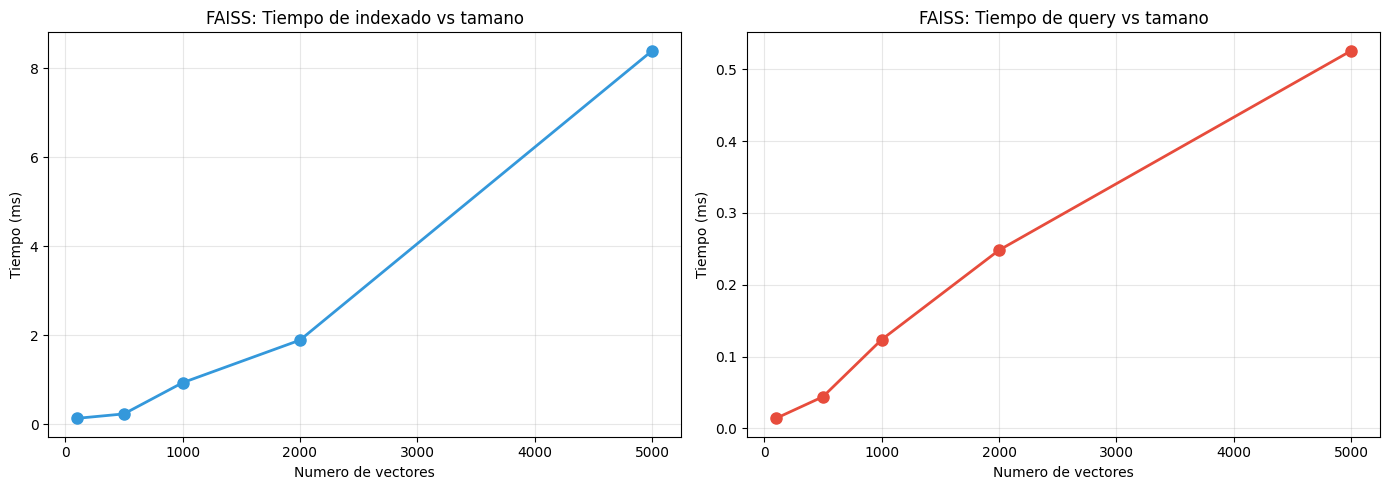

FAISS Scale Test:
    100 vectores: indexado 0.13 ms, query 0.014 ms
    500 vectores: indexado 0.23 ms, query 0.044 ms
   1000 vectores: indexado 0.93 ms, query 0.124 ms
   2000 vectores: indexado 1.89 ms, query 0.248 ms
   5000 vectores: indexado 8.40 ms, query 0.526 ms


In [23]:
# Scale test: FAISS con embeddings sinteticos
sizes = [100, 500, 1000, 2000, 5000]
index_times = []
query_times = []

for n in sizes:
    # Generar vectores sinteticos
    synthetic = np.random.randn(n, 1536).astype(np.float32)
    q_synthetic = np.random.randn(1, 1536).astype(np.float32)

    # Indexar
    start = time.perf_counter()
    idx = faiss.IndexFlatL2(1536)
    idx.add(synthetic)
    index_times.append(time.perf_counter() - start)

    # Query (promedio de 10)
    start = time.perf_counter()
    for _ in range(10):
        idx.search(q_synthetic, k=5)
    query_times.append((time.perf_counter() - start) / 10)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(sizes, [t*1000 for t in index_times], 'o-', color='#3498db',
             linewidth=2, markersize=8)
axes[0].set_xlabel('Numero de vectores')
axes[0].set_ylabel('Tiempo (ms)')
axes[0].set_title('FAISS: Tiempo de indexado vs tamano')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sizes, [t*1000 for t in query_times], 'o-', color='#e74c3c',
             linewidth=2, markersize=8)
axes[1].set_xlabel('Numero de vectores')
axes[1].set_ylabel('Tiempo (ms)')
axes[1].set_title('FAISS: Tiempo de query vs tamano')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("FAISS Scale Test:")
for n, it, qt in zip(sizes, index_times, query_times):
    print(f"  {n:>5} vectores: indexado {it*1000:.2f} ms, query {qt*1000:.3f} ms")

---
## Seccion 7: Mejores Practicas

| Aspecto | Recomendacion |
|---------|---------------|
| **Chunk size** | 500-1000 chars para documentos generales. Ajustar segun el tipo de contenido |
| **Overlap** | 10-20% del chunk_size. Muy poco overlap pierde contexto en los bordes |
| **Modelo de embeddings** | OpenAI para mejor calidad, HuggingFace para privacidad y costo |
| **Base vectorial** | ChromaDB para prototipos, FAISS para rendimiento, Pinecone/Weaviate para produccion cloud |
| **Metadata** | Siempre agregar metadata para filtrado posterior (categoria, fecha, fuente) |
| **Persistencia** | Siempre persistir indices en produccion. Agregar directorios a .gitignore |
| **Evaluacion** | Medir relevancia con keywords esperadas o evaluacion humana |
| **k (top-k)** | Empezar con k=3-5. Mas k = mas contexto pero mas ruido |

In [24]:
# Cleanup de directorios persistidos
for dir_path in [CHROMA_DIR, FAISS_DIR]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print(f"Eliminado: {dir_path}")

print("\nCleanup completado.")

Eliminado: ./chroma_persist_demo
Eliminado: ./faiss_persist_demo

Cleanup completado.


---
## Resumen

En esta notebook aprendimos:

| Concepto | Descripcion |
|----------|-------------|
| FAISS | Libreria de Meta para busqueda vectorial de alto rendimiento |
| Chunking | Division de documentos en fragmentos con diferentes estrategias |
| Chunk overlap | Repeticion controlada entre chunks para no perder contexto |
| Persistencia | Guardar y cargar indices para no re-indexar cada vez |
| Modelos de embeddings | OpenAI vs HuggingFace: calidad vs privacidad/costo |
| Benchmarking | Medir indexado, query y memoria para elegir la mejor herramienta |

### Checklist de consolidacion

- [ ] Puedo crear un indice FAISS y hacer busquedas
- [ ] Entiendo el impacto del chunk size en la calidad del retrieval
- [ ] Se persistir y recargar un indice (Chroma y FAISS)
- [ ] Puedo comparar modelos de embeddings con metricas concretas
- [ ] Comprendo las diferencias de rendimiento entre FAISS y ChromaDB
- [ ] Se elegir la herramienta adecuada segun el caso de uso